In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg as LA
from numpy.random import default_rng
import pywt
import ham_cr

In [2]:
rand = default_rng(11)
x1_size = rand.exponential(size=2)
x1_sign = np.sign(2.*rand.random(size=2) - 1.)
x1 = x1_sign * x1_size
print(x1)

[ 0.22959243 -0.53830701]


In [3]:
# generate a complete data set of {cV, \chi_z, M_z} for one set of random Stevens parameters
# Comment: we could think to make a class that generates a full set of N training data sets (from N random Stevens parameters - then N would be given to the class). Here, the random drawing of Stevens parameters happens outside the class. 

class training_data:
    """
    Class generates and output training data: specific_heat(T), susceptibility(T) and magnetization(T, B) along specified direction(s). 
    (Optional) parameters that can be provided at instantiation: 
        point_group: Point group defined form of crystal field Hamiltonian (set to 'Oh' per default)
        N_t: Number of training sets = number of randomly chosen Stevens parameter sets. (Set to 1 per default)
        rng_seed: seed of random number generator that draws Stevens parameters (set to 1 per default)
        J, L, S: angular momentum of ion (set to J=4, L=5, S=1 per default)
        B_directions: magnetic field directions that are considered in susc and mag (set to [[0,0,1]] per default)

    Functions: 
    """

    # Bohr magneton over Boltzmann constant
    # Used to transform magnetic field B from unitsof Tesla to units of Kelvin: [muB*B/k_B] = Kelvin with [B] = Tesla
    muB_over_kB = 0.671713816 

    def __init__(self, point_group = 'Oh', N_t = 1, rng_seed = 1, J = 4, L = 5, S = 1, B_directions = [[0,0,1]]):
        self.point_group = point_group
        self.N_t = N_t
        self.rng_seed = rng_seed
        self.rg = default_rng(rng_seed)
        self.J = J
        self.L = L
        self.S = S
        self.B_directions = B_directions

    ###### define angular momentum operators Jx_op, Jy_op, Jz_op for a given J value #####
    def Jz_op(self):
        mat = np.diag(np.arange(2*self.J+1,dtype=np.float) - self.J)
        return mat

    def Jplus_op(self):
        mat = np.diag(np.sqrt((2*self.J - np.arange(2*self.J))*(np.arange(2*self.J)+1)), -1)
        return mat

    def Jminus_op(self):
        mat = np.diag(np.sqrt((2*self.J - np.arange(2*self.J))*(np.arange(2*self.J)+1)), 1)
        return mat

    def Jx_op(self):
        mat = (self.Jplus_op() + self.Jminus_op())/2.
        return mat

    def Jy_op(self):
        mat = -1j/2.*(self.Jplus_op() - self.Jminus_op())
        return mat

    def gJLS(self):
        return 1 + (self.J*(self.J + 1) + self.S*(self.S+1) - self.L*(self.L+1))/(2*self.J*(self.J + 1))

    ####### Draw random Stevens paramaters #######################################

    def generate_random_stevens(self, range):
        """
        Generated random values for Stevens parameters for given point group. 

        Parameters: 
            ppoint_group: string of point group in Schoenflies notation
            range: array of ranges for Stevens parameters [[x0_min, x0_max], [x1_min, x1_max], ...] 
        Returns: 
            stevens_params: array with random instances of Stevens parameters
        """
        # TO DO: implement error messages if range is not correct: in particular, it will get stuck if the range of the x_1, ..., x_{N-1} is not given by [-1,1]
        if self.point_group == 'Oh': # two Stevens parameters for m-3m = Oh point group
            x0 = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
            x1 = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
            stevens_params = np.array([x0, x1])
        elif self.point_group == "C4v": # 5 Stevens parameters for 4mm = C4v point group
            stevens_params = np.array([1.,1.,1.,1.,1., 0.])
            while (np.sum(np.abs(stevens_params)) - np.abs(stevens_params[0]) - np.abs(stevens_params[-1]) > 1):
                stevens_params[0] = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
                stevens_params[1] = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
                stevens_params[2] = range[2][0] + (range[2][1] - range[2][0])*self.rg.random()
                stevens_params[3] = range[3][0] + (range[3][1] - range[3][0])*self.rg.random()
                stevens_params[4] = range[4][0] + (range[4][1] - range[4][0])*self.rg.random()
            stevens_params[5] = 2.*self.rg.random() - 1. # only sign of x5 matters as size is determined by x1, .., x4. 
        elif self.point_group == "D3h": # 4 Stevens parameters for -6m2 = D3h point group
            stevens_params = np.array([1.,1.,1.,1., 0.])
            while (np.sum(np.abs(stevens_params)) - np.abs(stevens_params[0]) - np.abs(stevens_params[-1]) > 1):
                stevens_params[0] = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
                stevens_params[1] = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
                stevens_params[2] = range[2][0] + (range[2][1] - range[2][0])*self.rg.random()
                stevens_params[3] = range[3][0] + (range[3][1] - range[3][0])*self.rg.random()
            stevens_params[4] = 2.*self.rg.random() - 1. # only sign of x5 matters as size is determined by x1, .., x4. 
        else:
            raise ValueError("This point group is not implemented.")
        return stevens_params
            
    ####### Define the crystal field Hamiltonian for given point group and J ##########
    def ham_cr(self, stevens_params):
        """
        Outputs crystal field Hamiltonian H in units of Kelvin. The units of H are set by the units of x0. We choose the range of x0 (=[1,50] Kelvin) that corresponds to [x0] = Kelvin. 

        Parameters: 
            stevens_params: array of Stevens parameters (check that length is correct). x0 has dimensions of energy (we use Kelvin) and x1, x2, ... are dimensionless in interval [-1,1].
        Returns: 
            ham_cr: crystal field Hamiltonian array 
        """
        if (self.point_group == 'Oh'):  
            if (len(stevens_params) != 2): 
                raise ValueError("Number of Stevens parameters should be 2 for point group Oh")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_Oh_J_4(stevens_params[0], stevens_params[1])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_Oh_J_7_5(stevens_params[0], stevens_params[1])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_Oh_J_3_5(stevens_params[0], stevens_params[1])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_Oh_J_6(stevens_params[0], stevens_params[1])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_Oh_J_8(stevens_params[0], stevens_params[1])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_Oh_J_4_5(stevens_params[0], stevens_params[1])
        elif (self.point_group == 'C4v'): 
            if (len(stevens_params) != 6): 
                raise ValueError("Number of Stevens parameters should be 5+1=6 for point group C4v")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_C4v_J_4(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_C4v_J_7_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_C4v_J_3_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_C4v_J_6(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_C4v_J_8(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_C4v_J_4_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])

        elif (self.point_group == 'D3h'): 
            if (len(stevens_params) != 5): 
                raise ValueError("Number of Stevens parameters should be 4+1=5 for point group D3h")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_D3h_J_4(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_D3h_J_7_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_D3h_J_3_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_D3h_J_6(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_D3h_J_8(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_D3h_J_4_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
        else: 
            raise ValueError("This point group and/or value of J is not implemented.")   

    ####### Calculate specific heat ##################################

    def specific_heat(self, ham, T_min=2, T_max=300, T_steps=150):
        """
        Returns array of cV/kB for a single rare-earth ion over temperature range [T_min, T_max] for hamiltonian matrix ham. Note that [cV/kB] is dimensionless. To get the specific heat, multiply the result with the Boltzmann constant kB. 

        Parameters: 
            ham : hermitian Hamiltonian matrix, typically of crystal field Hamiltonian (dimension 2*J+1)
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range

        Returns: 
            cV_array: cV/kB for a single rare-earth ion. Array of dimension (T_steps, 2) containing (T_i, cV/kB(T_i) ),             where T_i is temperature at step i 

        """  
        T = np.linspace(T_min, T_max, T_steps) # linearly spaced temperatures
        energies = LA.eigvalsh(ham)
        energies = energies - energies[0]

        # partition function for zero field
        def Z_cr(T):
            return np.sum(np.exp(-energies/T))
        
        # specific heat expression
        def cV(T):
            return 1./(T**2) * (np.sum(energies**2 * np.exp(-energies/T))/Z_cr(T) - np.sum(energies * np.exp(-energies/T)/Z_cr(T))**2)

        cV_array = np.zeros((len(T), 2))

        #this can probably be optimized using numpy ufuncs, but it is ok for now
        for i in range(0, len(cV_array)):
            cV_array[i][0] = T[i]
            cV_array[i][1] = cV(T[i])
    
        return cV_array

    ######### Calculate magnetization ##############################

    def magnetization(self, ham_cr, B_direction, B_min=0, B_max=10, B_steps=20, T_min=2, T_max=300, T_steps=4):
        """
        Returns array of moment per R-ion mu/mu_B (over mu_B) over temperature and magnetic field range [T_min, T_max] and [B_min, B_max] for a system with zero-field Hamiltonian matrix ham_cr. Note mu/mu_B is dimensionless. The magnetic field is along B_direction (x, y, z).  
        Parameters: 
            ham_cr : hermitian Hamiltonian matrix in zero field, typically of crystal field Hamiltonian (dimension 2*J+1)
            B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
            B_min: minimal field (in Tesla)
            B_max: maximal field (in Tesla)
            B_steps: total number of steps in field range
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range

        Returns: 
            mag_array: induced moment on R-ion mu/muB in array of dimension (T_steps, B_steps, 2) containing (B_i, T_i, mag(B_i, T_i) ), where T_i (B_i) is temperature (field) at step i. Note that this differs by a factor of gJLS from a previous version of the function. 

        """  
        gJLS = float(self.gJLS())

        T_array = np.geomspace(T_min, T_max, T_steps)
        B_array = np.linspace(B_min, B_max, B_steps)

        B_direction = B_direction/LA.norm(B_direction)
        J_op = B_direction[0]*self.Jx_op() + B_direction[1]*self.Jy_op() + B_direction[2]*self.Jz_op()

        mag_array = np.zeros((len(B_array), len(T_array), 3))

        # this can probably be optimized using numpy ufuncs, but it is ok for now
        for B_idx in np.arange(0, len(B_array)):
            B = B_array[B_idx]
            ham = ham_cr - gJLS*self.muB_over_kB*J_op*B
            energies, eigenstates = LA.eigh(ham)
            energies = energies - energies[0]
            
            for T_idx in range(0, len(T_array)):
                T = T_array[T_idx]
                ZB = np.sum(np.exp(-energies/T))
                # mag = \mu/\mu_B is moment per R-ion over Bohr magneton. mag is dimensionless. 
                mag = gJLS/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])
    
                mag_array[B_idx][T_idx][0] = B_array[B_idx]
                mag_array[B_idx][T_idx][1] = T_array[T_idx]
                mag_array[B_idx][T_idx][2] = mag

        return mag_array
    
    ########### Calculate magnetic susceptibility ############################
    
    def susceptibility(self, ham_cr, B_direction, B=0.0001, T_min=1, T_max=300, T_steps=300):
        """
        Calculated and returns magnetic susceptibility chi_a = mu/(mu_B*B) (units of 1/T) over temperature range [T_min, T_max] for zero-field Hamiltonian matrix ham_cr. Here, mu is the induced moment on the R-ion, mu_B is the Bohr magneton and B the magnetic field. The direction is a=B_direction .
        Parameters: 
            ham_cr : hermitian Hamiltonian matrix in zero field, typically a crystal field Hamiltonian (dimension 2*J+1)
            B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
            B: B field used in susceptibility calculation (in Tesla). Should be << all other energy scales. 
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range
            
        Returns: 
            susc_array: array of dimension (T_steps, 2) containing (T_i, mu(T_i)/(muB*B), where T_i is temperature at step i and mu(T_i)/mu_B = mag(T_i) is the field induced moment on the R-ion. Note that this differs by a factor of gJLS from a previous version of the function. 

        """  
        gJLS = float(self.gJLS())

        T_array = np.linspace(T_min, T_max, T_steps)

        B_direction = B_direction/LA.norm(B_direction)
        J_op = B_direction[0]*self.Jx_op() + B_direction[1]*self.Jy_op() + B_direction[2]*self.Jz_op()

        susc_array = np.zeros((len(T_array), 2))

        # this can probably be optimized using numpy ufuncs, but it is ok for now  
        # B is given in units of T, ham is in units of K.
        ham = ham_cr - gJLS*self.muB_over_kB*J_op*B
        energies, eigenstates = LA.eigh(ham)
        energies = energies - energies[0]
            
        for T_idx in range(0, len(T_array)):
                T = T_array[T_idx]
                ZB = np.sum(np.exp(-energies/T))
                # mag = mu/mu_B, where \mu is the field induced moment on the R-ion
                mag = gJLS/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])

                susc_array[T_idx][0] = T_array[T_idx]
                # susc = mag/B = \mu/(\mu_B B) has units of 1/T
                susc_array[T_idx][1] = mag/B 

        return susc_array

    ######## Output training data into files #################

    def output_all_data(self, Stevens_range, cV_T_range = [1, 300, 100], susc_T_range = [1, 300, 100], mag_T_range = [1, 300, 4], mag_B_range = [0.5, 10, 20]):
        """
        Write training data to file
        Parameters: 
            Stevens_range: array of ranges for Stevens parameters [[x0_min, x0_max], [x1_min, x1_max], ...] 
        Optional parameters: 
            cV_T_range: [T_min, T_max, T_steps] array for specific heat calculation
            susc_T_range: [T_min, T_max, T_steps] array for susceptibility calculation
            mag_T_range: [T_min, T_max, T_steps] array for magnetization calculation
            mag_B_range: [B_min, B_max, B_steps], where B_steps is the number of B points within range [B_min, B_max]
        Returns: 
            stevens_params_all: array with parameter values of Stevens parameters
            cV_data_all: array with specific heat values
            susc_data_all: array with susceptibility values
            mag_data_all: array with magnetization values

        """
        stevens_params_all = [] 
        cV_data_all = []
        susc_data_all = []
        mag_data_all = []
        for N_t_idx in range(0, self.N_t):
            stevens_params = self.generate_random_stevens(Stevens_range) # draw random Stevens parameters
            stevens_params_all.append(stevens_params) # use a list to store all Stevens parameters. Since different point groups have different number of Stevens parameters, the tuples that are stored have different length. 
            ham_cr = self.ham_cr(stevens_params) # crystal field Hamiltonian for given random Stevens parameters

            # generate specific heat data and store in cV_data
            cV_data_all.append(self.specific_heat(ham_cr, T_min = cV_T_range[0], T_max = cV_T_range[1], T_steps = cV_T_range[2]))

            B_direction_steps = len(self.B_directions)

            # generate susceptibility data and store in susc_data (for all B_directions)
            susc_data = np.zeros((susc_T_range[2], 1 + B_direction_steps))
            mag_data = np.zeros((mag_B_range[2], mag_T_range[2], 2 + B_direction_steps))
            
            for B_direction_idx in range (0, B_direction_steps):
                B_direction = self.B_directions[B_direction_idx]
                susc_array = self.susceptibility(ham_cr, B_direction, B = 0.0001, T_min = susc_T_range[0], T_max = susc_T_range[1], T_steps = susc_T_range[2])
                mag_array = self.magnetization(ham_cr, B_direction, B_min = mag_B_range[0], B_max = mag_B_range[1], B_steps = mag_B_range[2], T_min = mag_T_range[0], T_max = mag_T_range[1], T_steps = mag_T_range[2])

                for T_idx in range (0, len(susc_array)):
                    if (B_direction_idx == 0): 
                        susc_data[T_idx][0] = susc_array[T_idx][0]
                    susc_data[T_idx][1 + B_direction_idx] = susc_array[T_idx][1]

                for B_idx in range (0, mag_B_range[2]):
                    for T_idx in range(0, mag_T_range[2]):
                        if (B_direction_idx == 0):
                            mag_data[B_idx][T_idx][0] = mag_array[B_idx][T_idx][0]
                            mag_data[B_idx][T_idx][1] = mag_array[B_idx][T_idx][1]
                        mag_data[B_idx][T_idx][2 + B_direction_idx] = mag_array[B_idx][T_idx][2]
            susc_data_all.append(susc_data)
            mag_data_all.append(mag_data)
        return stevens_params_all, cV_data_all, susc_data_all, mag_data_all

    

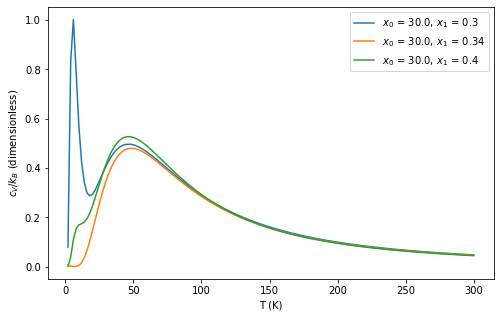

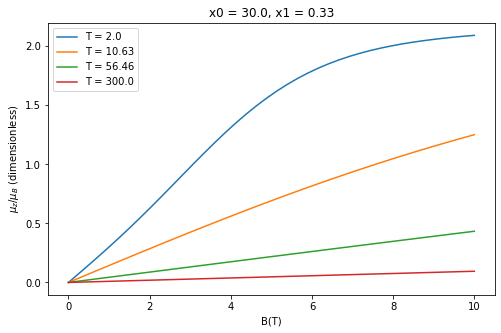

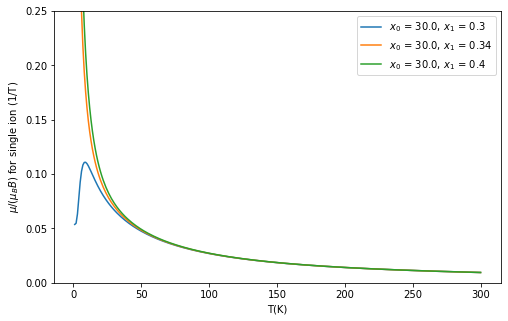

In [4]:
# Show plots of the output for PG 'Oh'
td = training_data('Oh', 1, 123, J=4, L=5, S=1)
td.Jz_op()
td.ham_cr([1., -0.32])
td.magnetization(td.ham_cr([1., -0.32]), [0,0,1], B_steps = 100)
td.susceptibility(td.ham_cr([4.25, -0.32]), [0,0,1])
x0 = 30.
x1 = 0.33

x0A = 30.
x1A = 0.3

x0B = 30.
x1B = 0.34

x0C = 30.
x1C = 0.4


cV_data1 = td.specific_heat(td.ham_cr([x0A, x1A]))
T1 = cV_data1[:, 0]
cV1 = cV_data1[:, 1]

cV_data2 = td.specific_heat(td.ham_cr([x0B, x1B]))
T2 = cV_data2[:, 0]
cV2 = cV_data2[:, 1]

cV_data3 = td.specific_heat(td.ham_cr([x0C, x1C]))
T3 = cV_data3[:, 0]
cV3 = cV_data3[:, 1]

fig = plt.figure(1, figsize = [8,5])
ax = plt.subplot(1,1,1)
ax.plot(T1, cV1, label = '$x_0$ = ' + str(round(x0A, 2)) + ", $x_1$ = " + str(round(x1A, 2)))
ax.plot(T2, cV2, label = '$x_0$ = ' + str(round(x0B, 2)) + ", $x_1$ = " + str(round(x1B, 2)))
ax.plot(T3, cV3, label = '$x_0$ = ' + str(round(x0C, 2)) + ", $x_1$ = " + str(round(x1C, 2)))
ax.set_xlabel('T (K)')
ax.set_ylabel('$c_V/k_B$ (dimensionless)')
ax.legend()

#fig.savefig("Graphics/Plot-cV-x0A_" + str(x0A) + "-x0C_" + str(x0C) + "-x1A_" + str(x1A) + "-x1C_" + str(x1C) + ".pdf", bbox_inches = "tight")

plt.show()

mag_data = td.magnetization(td.ham_cr([x0, x1]), [0,0,1], B_steps = 40, B_max = 10)
B1 = mag_data[:, 0, 0]
mag1 = mag_data[:, 0, 2]
B2 = mag_data[:, 1, 0]
mag2 = mag_data[:, 1, 2]
B3 = mag_data[:, 2, 0]
mag3 = mag_data[:, 2, 2]
B4 = mag_data[:, 3, 0]
mag4 = mag_data[:, 3, 2]

fig = plt.figure(1, figsize = [8,5])
ax = plt.subplot(1,1,1)
ax.plot(B1, mag1, label='T = '+str(round(mag_data[0, 0, 1],2)))
ax.plot(B2, mag2, label='T = '+str(round(mag_data[0, 1, 1],2)))
ax.plot(B3, mag3,  label='T = '+str(round(mag_data[0, 2, 1],2)))
ax.plot(B4, mag4,  label='T = '+str(round(mag_data[0, 3, 1],2)))
ax.set_xlabel('B(T)')
ax.set_ylabel('$\mu_z/\mu_B$ (dimensionless)')
ax.set_title('x0 = ' + str(x0) + ', x1 = ' + str(x1))
ax.legend()
#plt.tight_layout()

#fig.savefig("Graphics/Plot-Mag-x0_" + str(x0) + "-x1_" + str(x1) + ".pdf", bbox_inches = "tight")

plt.show()

susc_data1 = td.susceptibility(td.ham_cr([x0A, x1A]), [0,0,1])
T1 = susc_data1[:, 0]
susc1 = susc_data1[:, 1]

susc_data2 = td.susceptibility(td.ham_cr([x0B, x1B]), [0,0,1])
T2 = susc_data2[:, 0]
susc2 = susc_data2[:, 1]

susc_data3 = td.susceptibility(td.ham_cr([x0C, x1C]), [0,0,1])
T3 = susc_data3[:, 0]
susc3 = susc_data3[:, 1]

fig = plt.figure(1, figsize = [8,5])
ax = plt.subplot(1,1,1)
ax.plot(T1, susc1, label = '$x_0$ = ' + str(round(x0A, 2)) + ", $x_1$ = " + str(round(x1A, 2)))
ax.plot(T2, susc2, label = '$x_0$ = ' + str(round(x0B, 2)) + ", $x_1$ = " + str(round(x1B, 2)))
ax.plot(T3, susc3, label = '$x_0$ = ' + str(round(x0C, 2)) + ", $x_1$ = " + str(round(x1C, 2)))
ax.set_xlabel('T(K)')
ax.set_ylabel('$\mu/(\mu_B B)$ for single ion (1/T)')
ax.set_ylim(top = 0.25, bottom = 0.)
ax.legend()

#fig.savefig("Graphics/Plot-Susc-x0A_" + str(x0A) + "-x0C_" + str(x0C) + "-x1A_" + str(x1A) + "-x1C_" + str(x1C) + ".pdf", bbox_inches = "tight")

plt.show()


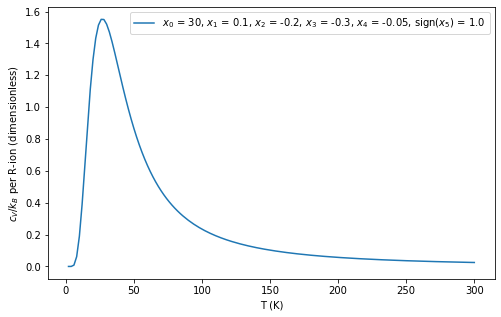

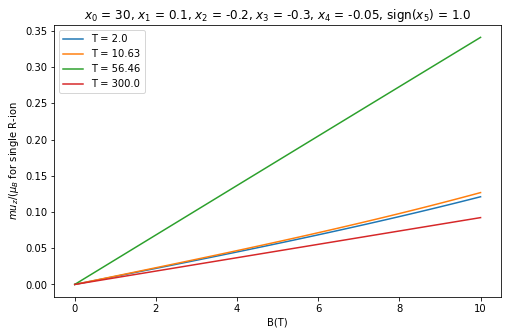

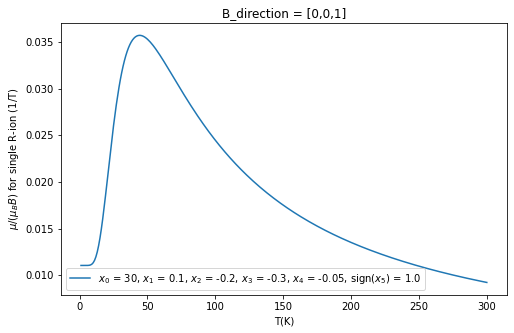

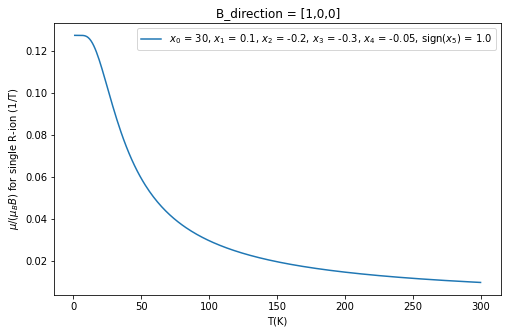

In [5]:
# Show plots of the output for PG 'C4v'
td = training_data('C4v', 1, 123, J=4, L=5, S=1)

x0 = 30
x1 = 0.1
x2 = -0.2
x3 = -0.3
x4 = -0.05
x5 = 1. # only sign of x5 matters 

cV_data = td.specific_heat(td.ham_cr([x0, x1, x2, x3, x4, x5]))
T = cV_data[:, 0]
cV = cV_data[:, 1]

fig = plt.figure(1, figsize = [8,5])
ax = plt.subplot(1,1,1)
ax.plot(T, cV, label = '$x_0$ = ' + str(round(x0, 2)) + ", $x_1$ = " + str(round(x1, 2)) + ", $x_2$ = " + str(round(x2, 2)) + ", $x_3$ = " + str(round(x3, 2)) + ", $x_4$ = " + str(round(x4, 2)) + ", sign($x_5$) = " + str(np.sign(x5)))
ax.set_xlabel('T (K)')
ax.set_ylabel('$c_V/k_B$ per R-ion (dimensionless)')
ax.legend()

#fig.savefig("Graphics/Plot-cV-x0A_" + str(x0A) + "-x0C_" + str(x0C) + "-x1A_" + str(x1A) + "-x1C_" + str(x1C) + ".pdf", bbox_inches = "tight")

plt.show()

mag_data = td.magnetization(td.ham_cr([x0, x1, x2, x3, x4, x5]), [0,0,1], B_steps = 40, B_max = 10)
B1 = mag_data[:, 0, 0]
mag1 = mag_data[:, 0, 2]
B2 = mag_data[:, 1, 0]
mag2 = mag_data[:, 1, 2]
B3 = mag_data[:, 2, 0]
mag3 = mag_data[:, 2, 2]
B4 = mag_data[:, 3, 0]
mag4 = mag_data[:, 3, 2]

fig = plt.figure(1, figsize = [8,5])
ax = plt.subplot(1,1,1)
ax.plot(B1, mag1, label='T = '+str(round(mag_data[0, 0, 1],2)))
ax.plot(B2, mag2, label='T = '+str(round(mag_data[0, 1, 1],2)))
ax.plot(B3, mag3,  label='T = '+str(round(mag_data[0, 2, 1],2)))
ax.plot(B4, mag4,  label='T = '+str(round(mag_data[0, 3, 1],2)))
ax.set_xlabel('B(T)')
ax.set_ylabel('$mu_z/(\mu_B$ for single R-ion')
ax.set_title('$x_0$ = ' + str(round(x0, 2)) + ", $x_1$ = " + str(round(x1, 2)) + ", $x_2$ = " + str(round(x2, 2)) + ", $x_3$ = " + str(round(x3, 2)) + ", $x_4$ = " + str(round(x4, 2)) + ", sign($x_5$) = " + str(np.sign(x5)))
ax.legend()
#plt.tight_layout()

#fig.savefig("Graphics/Plot-Mag-x0_" + str(x0) + "-x1_" + str(x1) + ".pdf", bbox_inches = "tight")

plt.show()

susc_data = td.susceptibility(td.ham_cr([x0, x1, x2, x3, x4, x5]), [0,0,1])
T = susc_data[:, 0]
susc = susc_data[:, 1]

fig = plt.figure(1, figsize = [8,5])
ax = plt.subplot(1,1,1)
ax.plot(T, susc, label = '$x_0$ = ' + str(round(x0, 2)) + ", $x_1$ = " + str(round(x1, 2)) + ", $x_2$ = " + str(round(x2, 2)) + ", $x_3$ = " + str(round(x3, 2)) + ", $x_4$ = " + str(round(x4, 2)) + ", sign($x_5$) = " + str(np.sign(x5)))
ax.set_xlabel('T(K)')
ax.set_ylabel('$\mu/(\mu_B B)$ for single R-ion (1/T)')  
ax.set_title('B_direction = [0,0,1]')
#ax.set_ylim(top = 0.25, bottom = 0.)
ax.legend()

#fig.savefig("Graphics/Plot-Susc-x0A_" + str(x0A) + "-x0C_" + str(x0C) + "-x1A_" + str(x1A) + "-x1C_" + str(x1C) + ".pdf", bbox_inches = "tight")

plt.show()

susc_data = td.susceptibility(td.ham_cr([x0, x1, x2, x3, x4, x5]), [1,0,0])
T = susc_data[:, 0]
susc = susc_data[:, 1]

fig = plt.figure(1, figsize = [8,5])
ax = plt.subplot(1,1,1)
ax.plot(T, susc, label = '$x_0$ = ' + str(round(x0, 2)) + ", $x_1$ = " + str(round(x1, 2)) + ", $x_2$ = " + str(round(x2, 2)) + ", $x_3$ = " + str(round(x3, 2)) + ", $x_4$ = " + str(round(x4, 2)) + ", sign($x_5$) = " + str(np.sign(x5)))
ax.set_xlabel('T(K)')
ax.set_ylabel('$\mu/(\mu_B B)$ for single R-ion (1/T)')
ax.set_title('B_direction = [1,0,0]')
#ax.set_ylim(top = 0.25, bottom = 0.)
ax.legend()

#fig.savefig("Graphics/Plot-Susc-x0A_" + str(x0A) + "-x0C_" + str(x0C) + "-x1A_" + str(x1A) + "-x1C_" + str(x1C) + ".pdf", bbox_inches = "tight")

plt.show()




In [6]:
td = training_data('D3h', 1, 123, J = 4, B_directions=[[0,0,1],[1,0,0]])
out = td.output_all_data(Stevens_range = [[1, 50], [-1,1], [-1,1],[-1,1],[-1,1]], cV_T_range = [1, 50, 10], susc_T_range = [1, 300, 5], mag_T_range = [1, 300, 4], mag_B_range = [0.5, 10, 5])
out[1] # Stevens parameters
#out[1] # specific heat [[T_i, cV^(0)_i], [T_i, cV^(1)_i], ..., [T_i, cV^(N_t-1)_i] ], i = 1, ..., T_steps
#out[2] # susceptibility [[T_i, susc^(0)_{0,i}, susc^{(0)_{1,i}, ..., susc^(0)_{B_direction-1,i}}], ...], i = 1, ..., T_steps
#out[3] # magnetization [[[B_j, T_i, M^(0),{0,i}, M^(0)_{1,i,j}, ..., M^(0)_{B_direction-1,i,j}], ... ]], j = 1, .., B_steps; i = 1, ..., T_steps


# It is straightforward to slice the output data and extract the part of the data that is needed for the ml part. 

[array([[1.00000000e+00, 3.15499693e-33],
        [6.44444444e+00, 8.09818377e-04],
        [1.18888889e+01, 1.17618210e-01],
        [1.73333333e+01, 5.71696594e-01],
        [2.27777778e+01, 1.07470532e+00],
        [2.82222222e+01, 1.36181770e+00],
        [3.36666667e+01, 1.43263074e+00],
        [3.91111111e+01, 1.37785901e+00],
        [4.45555556e+01, 1.27033258e+00],
        [5.00000000e+01, 1.14943140e+00]])]

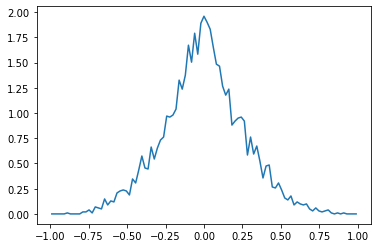

In [7]:
# this cell implements a method that ensures we are drawing uniform from the simplex defined by \sum_{i=1}^N |x_i| = 1$. This method is described in http://blog.geomblog.org/2005/10/sampling-from-simplex.html, for example. We draws from an exponential distribution in the unit cube and then projects onto the simplex surface. 
rand = default_rng(11)
size_rand = 5000
x_array = np.zeros((size_rand, 5))
for i_size in range(0, size_rand):
    x1_size = -np.log(rand.random())
    x1_sign = np.sign(2.*rand.random() - 1.)
    xx1 = x1_sign * x1_size
    x2_size = -np.log(rand.random())
    x2_sign = np.sign(2.*rand.random() - 1.)
    xx2 = x2_sign * x2_size
    x3_size = -np.log(rand.random())
    x3_sign = np.sign(2.*rand.random() - 1.)
    xx3 = x3_sign * x3_size
    x4_size = -np.log(rand.random())
    x4_sign = np.sign(2.*rand.random() - 1.)
    xx4 = x4_sign * x4_size
    x5_size = -np.log(rand.random())
    x5_sign = np.sign(2.*rand.random() - 1.)
    xx5 = x5_sign * x5_size

    x_all= np.array([xx1, xx2, xx3, xx4, xx5])
    x_norm = np.sum(abs(x_all))
    #print(x_all, x_norm)
    #print(x_all/x_norm, np.sum(abs(x_all)/x_norm))
    #print(np.sum(abs(x_all)/x_norm))
    x_array[i_size] = x_all/x_norm

bins = np.linspace(-1, 1, 100)
histogram0, bins = np.histogram(x_array[:,0], bins=bins, density=True)
histogram1, bins = np.histogram(x_array[:,1], bins=bins, density=True)
histogram2, bins = np.histogram(x_array[:,2], bins=bins, density=True)
histogram3, bins = np.histogram(x_array[:,3], bins=bins, density=True)
histogram4, bins = np.histogram(x_array[:,4], bins=bins, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram0, label="Histogram of samples")

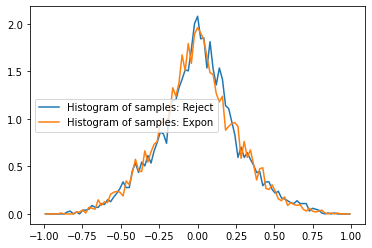

In [36]:
# this shows that the rejection method that is implemented in training_data class draws the Stevens parameters x_i uniform from the simplex defined by \sum_{i=1}^N |x_i| = 1. This is demonstrated by comparison to the method where one draws from an exponential distribution in the unit cube and then projects onto the simplex surface. 
x1_list = np.zeros(len(out[0]))
for i in range(0, len(out[0])):
    x1_list[i] = out[0][i][1]

bins = np.linspace(-1, 1, 100)
histogram, bins = np.histogram(x1_list, bins=bins, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Histogram of samples: Reject")
plt.plot(bin_centers, histogram0, label="Histogram of samples: Expon")
plt.legend()

In [37]:
with np.printoptions(precision=4, suppress=True):    
    print(ham_cr.ham_cr_PG_Oh_J_4(1., -0.32))

[[-0.4937  0.      0.      0.     -2.8523  0.      0.      0.      0.    ]
 [ 0.      0.2057  0.      0.      0.     -0.2644  0.      0.      0.    ]
 [ 0.      0.      1.6106  0.      0.      0.      1.3049  0.      0.    ]
 [ 0.      0.      0.     -0.3938  0.      0.      0.     -0.2644  0.    ]
 [-2.8523  0.      0.      0.     -1.8574  0.      0.      0.     -2.8523]
 [ 0.     -0.2644  0.      0.      0.     -0.3938  0.      0.      0.    ]
 [ 0.      0.      1.3049  0.      0.      0.      1.6106  0.      0.    ]
 [ 0.      0.      0.     -0.2644  0.      0.      0.      0.2057  0.    ]
 [ 0.      0.      0.      0.     -2.8523  0.      0.      0.     -0.4937]]


In [ ]:
# The code below is redundant. It will be rexported to a different file for backup purposes in later version. It should not be included in the final version of the py file. I wrote it in the process of developing the training_data() class and it is useful to check the code (by comparison witht the Mathematica file).

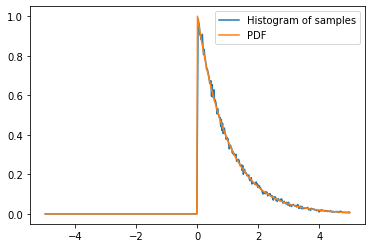

In [20]:
rand = default_rng(11)
2*rand.random() - 1.
samples = rand.exponential(size = 100000)
# Compute a histogram of the sample
bins = np.linspace(-5, 5, 500)
histogram, bins = np.histogram(samples, bins=bins, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

# Compute the PDF on the bin centers from scipy distribution object
from scipy import stats
pdf = stats.expon.pdf(bin_centers)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Histogram of samples")
plt.plot(bin_centers, pdf, label="PDF")
plt.legend()
plt.show()


In [38]:
def Jz_op(J):
    mat = np.diag(np.arange(2*J+1,dtype=np.float) - J)
    return mat

def Jplus_op(J):
    mat = np.diag(np.sqrt((2*J - np.arange(2*J))*(np.arange(2*J)+1)), -1)
    return mat

def Jminus_op(J):
    mat = np.diag(np.sqrt((2*J - np.arange(2*J))*(np.arange(2*J)+1)), 1)
    return mat

def Jx_op(J):
    mat = (Jplus_op(J) + Jminus_op(J))/2.
    return mat

def Jy_op(J):
    mat = -1j/2.*(Jplus_op(J) - Jminus_op(J))
    return mat
    
# with np.printoptions(precision=4, suppress=True):
#     print(Jx_op(4))

In [39]:
def specific_heat(ham, T_min=1, T_max=51, T_steps=500):
    """
    Returns array of specific heat over temperature range [T_min, T_max] for hamiltonian matrix ham

    Parameters: 
        ham : hermitian Hamiltonian matrix, typically of crystal field Hamiltonian (dimension 2*J+1)
        T_min : minimal temperature in Kelvin
        T_max : maximal temprature in Kelvin
        T_steps: total number of steps in temperature range

    Returns: 
        cV_array: specific heat array of dimension (T_steps, 2) containing (T_i, specific_heat(T_i) ), where T_i is temperature at step i 

    """  
    T = np.linspace(T_min, T_max, T_steps) # linearly spaced temperatures
    energies = LA.eigvalsh(ham)
    energies = energies - energies[0]

    # partition function for zero field
    def Z_cr(T):
        return np.sum(np.exp(-energies/T))
    
    # specific heat expression
    def cV(T):
        return 1./(T**2) * (np.sum(energies**2 * np.exp(-energies/T))/Z_cr(T) - np.sum(energies * np.exp(-energies/T)/Z_cr(T))**2)

    cV_array = np.zeros((len(T), 2))

    # this can probably be optimized using numpy ufuncs, but it is ok for now
    for i in range(0, len(cV_array)):
        cV_array[i][0] = T[i]
        cV_array[i][1] = cV(T[i])
  
    return cV_array

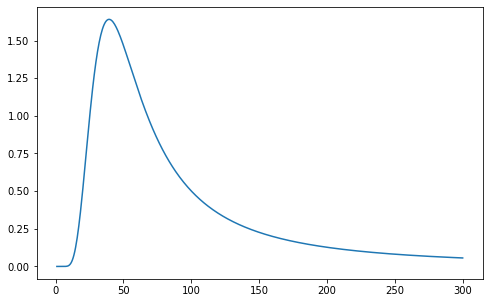

In [40]:

cV_data = specific_heat(ham_cr.ham_cr_PG_Oh_J_4(24.3628, -0.033), T_max=300)
T = cV_data[:, 0]
cV = cV_data[:, 1]

fig = plt.figure(1, figsize = [8,5])
ax = plt.plot(T, cV)
plt.show()

In [41]:
def magnetization(ham_cr, B_direction, B_min=0, B_max=10, B_steps=1, T_min=1, T_max=300, T_steps=4, J=4, L=5, S=1):
    """
    Returns array of magnetization over temperature and magnetic field range [T_min, T_max] and [B_min, B_max] for a system with zero-field Hamiltonian matrix ham_cr. The magnetic field is along B_direction (x, y, z).  
    Parameters: 
        ham_cr : hermitian Hamiltonian matrix in zero field, typically of crystal field Hamiltonian (dimension 2*J+1)
        B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
        B_min: minimal field (in Tesla)
        B_max: maximal field (in Tesla)
        B_steps: total number of steps in field range
        T_min : minimal temperature in Kelvin
        T_max : maximal temprature in Kelvin
        T_steps: total number of steps in temperature range
        J, L, S: determine the g-factor (using LS coupling scheme)

    Returns: 
        mag_array: magnetization/(gJLS*muB) array of dimension (T_steps, B_steps, 2) containing (T_i, B_i, specific_heat(T_i) ), where T_i (B_i) is temperature (field) at step i 

    """  
    muB_over_kB = 0.671713816
    gJLS = 0.8 # eventually make LS formula depending on J, L, S

    T_array = np.geomspace(T_min, T_max, T_steps)
    B_array = np.linspace(B_min, B_max, B_steps)

    B_direction = B_direction/LA.norm(B_direction)
    J_op = B_direction[0]*Jx_op(J) + B_direction[1]*Jy_op(J) + B_direction[2]*Jz_op(J)

    mag_array = np.zeros((len(B_array), len(T_array), 3))

    # this can probably be optimized using numpy ufuncs, but it is ok for now
    
    for B_idx in np.arange(0, len(B_array)):
        B = B_array[B_idx]
        ham = ham_cr - gJLS*muB_over_kB*J_op*B
        energies, eigenstates = LA.eigh(ham)
        energies = energies - energies[0]
        
        for T_idx in range(0, len(T_array)):
            T = T_array[T_idx]
            ZB = np.sum(np.exp(-energies/T))
            mag = 1/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])
   
            mag_array[B_idx][T_idx][0] = B_array[B_idx]
            mag_array[B_idx][T_idx][1] = T_array[T_idx]
            mag_array[B_idx][T_idx][2] = mag

    return mag_array

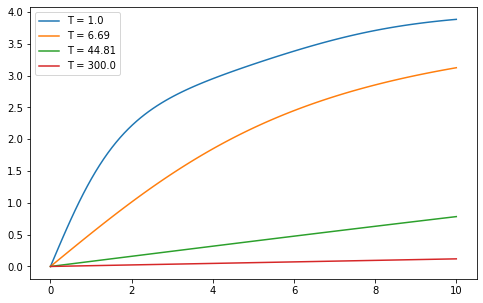

In [55]:
mag_data = magnetization(ham_cr.ham_cr_PG_Oh_J_4(1., -0.32), [0,0,1], B_steps = 100)
B1 = mag_data[:, 0, 0]
mag1 = mag_data[:, 0, 2]
B2 = mag_data[:, 1, 0]
mag2 = mag_data[:, 1, 2]
B3 = mag_data[:, 2, 0]
mag3 = mag_data[:, 2, 2]
B4 = mag_data[:, 3, 0]
mag4 = mag_data[:, 3, 2]

fig = plt.figure(1, figsize = [8,5])
ax = plt.plot(B1, mag1, label='T = '+str(round(mag_data[0, 0, 1],2)))
ax = plt.plot(B2, mag2, label='T = '+str(round(mag_data[0, 1, 1],2)))
ax = plt.plot(B3, mag3,  label='T = '+str(round(mag_data[0, 2, 1],2)))
ax = plt.plot(B4, mag4,  label='T = '+str(round(mag_data[0, 3, 1],2)))
ax = plt.legend()


plt.show()

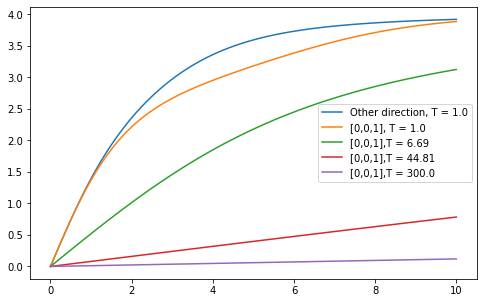

In [60]:
mag_data_2 = magnetization(ham_cr.ham_cr_PG_Oh_J_4(1., -0.32), [0,1,1], B_steps = 100)


B0 = mag_data_2[:, 0, 0]
mag0 = mag_data_2[:, 0, 2]

B1 = mag_data[:, 0, 0]
mag1 = mag_data[:, 0, 2]
B2 = mag_data[:, 1, 0]
mag2 = mag_data[:, 1, 2]
B3 = mag_data[:, 2, 0]
mag3 = mag_data[:, 2, 2]
B4 = mag_data[:, 3, 0]
mag4 = mag_data[:, 3, 2]

fig = plt.figure(1, figsize = [8,5])
ax = plt.plot(B0, mag0, label='Other direction, T = '+str(round(mag_data[0, 0, 1],2)))
ax = plt.plot(B1, mag1, label='[0,0,1], T = '+str(round(mag_data[0, 0, 1],2)))
ax = plt.plot(B2, mag2, label='[0,0,1],T = '+str(round(mag_data[0, 1, 1],2)))
ax = plt.plot(B3, mag3,  label='[0,0,1],T = '+str(round(mag_data[0, 2, 1],2)))
ax = plt.plot(B4, mag4,  label='[0,0,1],T = '+str(round(mag_data[0, 3, 1],2)))
ax = plt.legend()

In [63]:
def susceptibility(ham_cr, B_direction, B=0.001, T_min=1, T_max=300, T_steps=1000, J=4, L=5, S=1):
    """
    Calculated and returns magnetic susceptibility chi_a = M/B in direction a=B_direction over temperature range [T_min, T_max] for zero-field Hamiltonian matrix ham_cr.
    Parameters: 
        ham_cr : hermitian Hamiltonian matrix in zero field, typically a crystal field Hamiltonian (dimension 2*J+1)
        B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
        B: B field used in susceptibility calculation (in Tesla). Should be << all other energy scales. 
        T_min : minimal temperature in Kelvin
        T_max : maximal temprature in Kelvin
        T_steps: total number of steps in temperature range
        J, L, S: determine the g-factor (using LS coupling scheme)

    Returns: 
        susc_array: susceptbility/(gJLS*muB) array of dimension (T_steps, 2) containing (T_i, susceptibility(T_i)/(gJLS*muB) ), where T_i is temperature at step i.  

    """  
    muB_over_kB = 0.671713816
    gJLS = 0.8 # eventually make LS formula depending on J, L, S

    T_array = np.linspace(T_min, T_max, T_steps)

    B_direction = B_direction/LA.norm(B_direction)
    J_op = B_direction[0]*Jx_op(J) + B_direction[1]*Jy_op(J) + B_direction[2]*Jz_op(J)

    susc_array = np.zeros((len(T_array), 2))

    # this can probably be optimized using numpy ufuncs, but it is ok for now  
    ham = ham_cr - gJLS*muB_over_kB*J_op*B
    energies, eigenstates = LA.eigh(ham)
    energies = energies - energies[0]
        
    for T_idx in range(0, len(T_array)):
            T = T_array[T_idx]
            ZB = np.sum(np.exp(-energies/T))
            mag = 1/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])

            susc_array[T_idx][0] = T_array[T_idx]
            susc_array[T_idx][1] = mag/B

    return susc_array

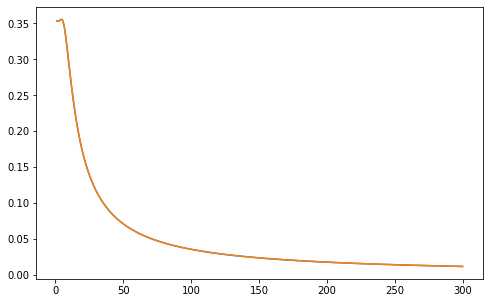

In [66]:
susc_data = susceptibility(ham_cr.ham_cr_PG_Oh_J_4(4.25, -0.32), [0,0,1])
susc_data_2 = susceptibility(ham_cr.ham_cr_PG_Oh_J_4(4.25, -0.32), [0,1,1])
T = susc_data[:, 0]
susc = susc_data[:, 1]
T_2 = susc_data_2[:, 0]
susc_2 = susc_data_2[:, 1]


fig = plt.figure(1, figsize = [8,5])
ax = plt.plot(T, susc)
ax = plt.plot(T_2, susc_2)
plt.show()

In [ ]:
point_groups = dict([('Oh', 32)])
# the random number generator should be initialized at the beginning of the program (or at class initialization). Important that it is only created once (as we provide an explicit seed).
rg = default_rng(1)
def generate_random_stevens(ppoint_group, range = [[1, 50], [-1, 1]]):
    """
    Generated random values for Stevens parameters for given point group. 

    Parameters: 
        ppoint_group: string of point group in Schoenflies notation
        range: array of ranges for Stevens parameters [[x0_min, x0_max], [x1_min, x1_max], ...] 
    Returns: 
        stevens_params: array with random instances of Stevens parameters
    """
    if ppoint_group == 'Oh': # two Stevens parameters for rm-3m = Oh point group
        x0 = range[0][0] + (range[0][1] - range[0][0])*rg.random()
        x1 = range[1][0] + (range[1][1] - range[1][0])*rg.random()
        stevens_params = np.array([x0, x1])
    else:
        raise ValueError("This point group is not implemented.")
    return stevens_params


In [ ]:
class data_generation:


    # def generate_susc_data(self, data):
    #     """
    #     Expression for susceptibility
        
    #     Args:
    #         data: Array of energy levels
    #     Returns:
    #         susc: Array of susceptibility values from 1K-100K at a given step size
    #     """
    # def generate_heat_data(self, data):
    #     """
    #     Expression for specific heat
        
    #     Args:
    #         data: Array of energy levels
    #     Returns:
    #         s_heat: Array of specific heat values from 1K-100K at a given step size
    #     """
    
    # def generate_mag_data(self, data):
    #     """
    #     Expression for magnetization
        
    #     Args:
    #         data: Array of energy levels
    #     Returns:
    #         MexpinBLowT: Array of magnetization values from 1T-10T at T=1.0
    #         MexpinBMidT: Array of magnetization values from 1T-10T at T=100.0
    #         MexpinBHighT: Array of magnetization values from 1T-10T at T=299.0
    #     """
    
    
    # def format_data(self, energyLevels):
    #     """
    #     Function to create energy levels matrix
        
    #     Args:
    #         energyLevels: Array of energy levels
    #     Returns:
    #         data: Formatted array of energy levels with a length of 9        
    #     """

################################### Automatic Data Generation  ###################################

    # def generate_energy_levels(self, num):
    #     """
    #     Generate num number of energy levels sets.
    #     E0 is set to 0. E3, E4, and E5 are the differences between E0 and the next levels.
        
    #     Args:
    #         num: Number of energy levels sets to generate
    #     Returns:
    #         energyLevels: Array of energy levels   
    #     """
    #     E1 = 0
    #     energyLevels = []
    #     for i in range(num):
    #         E3 = np.random.uniform(low=-75.0, high=75.0)
    #         E4 = np.random.uniform(low=-75.0, high=75.0)
    #         E5 = np.random.uniform(low=-75.0, high=75.0)
    #         new_target = [E1, E3, E4, E5]
    #         energyLevels.append(new_target)
    #     return energyLevels

    
    def generate_data(self, num):
        """
        Generate num number of energy level sets.
        Also generate susceptibility, specific heat, and magnetization data.
        
        Args:
            num: Number of examples to generate
        Returns:
            eLs: Array of energy levels
            data: Array of specific heat, susceptibility, and magnetization data, in that order
        """
        eLs = self.generate_energy_levels(num)
        data = []
        
        for i in range(len(eLs)):
            row = []
            row = self.generate_heat_data(eLs[i]) + self.generate_susc_data(eLs[i])
           
            low, mid, high = dg.generate_mag_data(eLs[i])
            row = row + np.asarray(low).ravel().tolist()
            row = row + np.asarray(mid).ravel().tolist()
#             row = row + np.asarray(high).ravel().tolist()

            if (i % 1000 == 0):
                print('{} training examples generated'.format(i))
            data.append(row)
            
        return (eLs, data)
        
##################################################################################################

In [ ]:
#[E3, E4, E5]
# energyLevels = [0, -7.868318060081819, 5.214400228782935, -51.170630907172594]
energyLevels = [0, np.random.uniform(low=-75.0, high=75.0), np.random.uniform(low=-75.0, high=75.0), np.random.uniform(low=-75.0, high=75.0)]

print('E1: {}'.format(energyLevels[0]))
print('E3: {}'.format(energyLevels[1]))
print('E4: {}'.format(energyLevels[2]))
print('E5: {}'.format(energyLevels[3]))

In [ ]:
#Generating susceptibility, specific heat, and magnetization data
susc = dg.generate_susc_data(energyLevels)
susc = pd.DataFrame(np.asarray(susc).ravel())
s_heat = pd.DataFrame(dg.generate_heat_data(energyLevels))

fig, (ax, ax2) = plt.subplots(ncols=2)
susc_plot = susc.plot(figsize=(11,5), title='Susceptibility', legend=False, ax=ax)
susc_plot.set_xlabel('T(K)')
s_heat_plot = s_heat.plot(figsize=(11,5),title='Specific Heat', legend=False, ax=ax2)
s_heat_plot.set_xlabel('T(K)')
plt.show()

low, mid, high = dg.generate_mag_data(energyLevels)
low_mag = pd.DataFrame(np.asarray(low).ravel())
mid_mag = pd.DataFrame(np.asarray(mid).ravel())
high_mag = pd.DataFrame(np.asarray(high).ravel())

fig2, (ax3, ax4, ax5) = plt.subplots(ncols=3, figsize=(17, 5))
low_mag_plot = low_mag.plot(title='Magnetization T=1', legend=False, ax=ax3)
mid_mag_plot = mid_mag.plot(title='Magnetization T=150', legend=False, ax=ax4)
high_mag_plot = high_mag.plot(title='Magnetization T=300', legend=False, ax=ax5)
plt.show()

In [ ]:
print(pywt.wavelist(kind='continuous'))
#gaus2
#morl

In [ ]:
time = np.arange(1,101)
scale = np.arange(1,101)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)
wave = 'morl'

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

[susc_coeff, susc_freq] = pywt.cwt(susc.squeeze(), scale, wave, 1)
susc_power = (abs(susc_coeff)) ** 2
susc_period = 1. / susc_freq

[sheat_coeff, sheat_freq] = pywt.cwt(s_heat.squeeze(), scale, wave, 1)
sheat_power = (abs(sheat_coeff)) ** 2
sheat_period = 1. / sheat_freq

[low_coeff, low_freq] = pywt.cwt(low_mag.squeeze(), scale, wave, 1)
low_power = (abs(low_coeff)) ** 2
low_period = 1. / low_freq
 
[mid_coeff, mid_freq] = pywt.cwt(mid_mag.squeeze(), scale, wave, 1)
mid_power = (abs(mid_coeff)) ** 2
mid_period = 1. / mid_freq
 
[hig_coeff, hig_freq] = pywt.cwt(high_mag.squeeze(), scale, wave, 1)
hig_power = (abs(hig_coeff)) ** 2
hig_period = 1. / hig_freq

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(11,11))
susc_plot = ax[0,0].contourf(time, np.log2(susc_period), np.log2(susc_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[0,0].set_title('Susceptibility')
ax[0,0].axis('off')
sheat_plot = ax[0,1].contourf(time, np.log2(sheat_period), np.log2(sheat_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[0,1].set_title('Specific Heat')
ax[0,1].axis('off')

low_mag_plot = ax[1,0].contourf(time, np.log2(low_period), np.log2(low_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[1,0].set_title('Magnetization T=1')
ax[1,0].axis('off')
mid_mag_plot = ax[1,1].contourf(time, np.log2(mid_period), np.log2(mid_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[1,1].set_title('Magnetization T=150')
ax[1,1].axis('off')
#hig_mag_plot = ax5.contourf(time, np.log2(hig_period), np.log2(hig_power), contourlevels, extend='both',cmap=plt.cm.seismic)
plt.savefig('cwt.png', bbox_inches='tight')
plt.show()


In [ ]:
# els = ['e1','e3','e4','e5']
# mul = [1,2,3,3]
# for i in range(len(els)-1):
#     for j in range(len(els),i+1,-1):
#         print(str(i) + str(j-1))
#         print(els[i] + els[j-1])
#         (mul[i] * mul[j-1]) * np.exp(-(els[i] + els[j-1])/beta(T)) * (els[i] - els[j-1])**2
#     print("\n")

In [ ]:
targets, data = dg.generate_data(1)
targets_df = pd.DataFrame(targets)
data_df = pd.DataFrame(data)
targets_df.to_csv('generated_targets_1.csv', header=None, index=None)
data_df.to_csv('generated_data_1.csv', header=None, index=None)

In [ ]:
# http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

# x axis is time (temperature or magnetization)
# y axis is period (1 / frequency) 
# color is power (related to the cwt coefficients)

# scale is related to how detailed different frequencies can be

In [ ]:
#  BACKUP OF NOAH'S CLASS: modified version is given above

class data_generation:
    # Magnetizations M and magnetizations squared M2 below correspond to the energy levels above
    M = [0, 0, 0, -0.5, 0.5, 0, 2.5, -2.5, 0]
    M2 = [(0.4564**2)*(4*5)*2, (0.5401**2)*(4*5)*2, (0.7071**2)*(2*3)*2, 
          (0.3536**2)*(3*4) + (0.9354**2)*(1*2), (0.3536**2)*(3*4) + 
          (0.9354**2)*(1*2), (0.7071**2)*(4*5)*2, (0.9354**2)*(3*4) +
          (0.3536**2)*(1*2), (0.9354**2)*(3*4) + (0.3536**2)*(1*2),
          (0.7071**2)*(2*3)*2]
    
    
    # Matrix that expresses the Gamma1, Gamma3, Gamma4, and Gamma5 
    # states in terms of Jz eigenstates whereJZ states are ordered by eigenvalue in descending order
    CFinJzbasis = np.matrix([[np.sqrt(5/24.), 0, 0, 0, np.sqrt(7/12.), 0, 0, 0, np.sqrt(5/24.)],
                            [np.sqrt(7/24.), 0, 0, 0, -np.sqrt(5/12.), 0, 0, 0, np.sqrt(7/24.)],
                            [0, 0, np.sqrt(1/2.), 0, 0, 0, np.sqrt(1/2.), 0, 0],
                            [0, np.sqrt(1/8.), 0, 0, 0, np.sqrt(7/8.), 0, 0, 0],
                            [0, 0, 0, np.sqrt(7/8.), 0, 0, 0, np.sqrt(1/8.), 0],
                            [-np.sqrt(1/2.), 0, 0, 0, 0, 0, 0, 0, np.sqrt(1/2.)],
                            [0, np.sqrt(7/8.), 0, 0, 0, -np.sqrt(1/8.), 0, 0, 0],
                            [0, 0, 0, -np.sqrt(1/8.), 0, 0, 0, np.sqrt(7/8.), 0],
                            [0, 0, -np.sqrt(1/2.), 0, 0, 0, np.sqrt(1/2.), 0, 0]])
    
    #Contribution of the magnetic field to the Hamiltonian
    mag_field = np.diag([4, 3, 2, 1, 0, -1, -2, -3, -4])
    CFinJzbasis_inv = LA.inv(CFinJzbasis)
    
    # Boltzmann constant. Since I am measuring everything in units of temperature it is set to 1
    kb = 1
    
    
    def beta(self, T):
        """
        Inverse temperature, rather useful to define in statistical physics     
        
        Args:
            T: Temperature in Kelvin   
        Returns:
            Inverse temperature    
        """
        return 1 / (self.kb * T)
    
    
    def generate_heat_data(self, data):
        """
        Expression for specific heat
        
        Args:
            data: Array of energy levels
        Returns:
            s_heat: Array of specific heat values from 1K-100K at a given step size
        """
        # Parse energy levels
        # el = self.format_data(data)
        el = data
        # Can change once we have Stephen's operators
        mul = [1,2,3,3]
        s_heat = []
        
        # Specific heat derived from second derivative of partition function, simplified. Took straight from Mathematica
        def c(T):
            if (len(el) != len(mul)):
                raise ValueError("Levels and multiplicity don't have same length")
            numer = lambda T: np.sum(np.sum([[(mul[i] * mul[j-1]) * np.exp(-(el[i] + el[j-1])/T) * (el[i] - el[j-1])**2 for j in range(len(el), i+1, -1)] for i in range(len(el)-1)]))
            denom = lambda T: (np.sum([mul[i]*np.exp(-el[i] * self.beta(T)) for i in range(len(el))])**2) * T**2
            return numer(T)/denom(T)
                
        # Change max temperature and step size
        temp = 200
        step = 2 
        for j in range(0, temp, step):
            s_heat.append(c(j+1))  
        return s_heat
    
    
    def generate_susc_data(self, data):
        """
        Expression for susceptibility
        
        Args:
            data: Array of energy levels
        Returns:
            susc: Array of susceptibility values from 1K-100K at a given step size
        """
        energyLevel = self.format_data(data)
        susc = []
        
        #Magnetic field is 1/1000th of the smallest energy differences
        B = min([abs(data[1]), abs(data[2]), abs(data[3]), abs(data[1]-data[2]), abs(data[2]-data[3]), abs(data[1]-data[3])])/1000        
        #Crystal field Hamiltonian (ie the original energy levels)
        HamCF = np.diag(energyLevel)
        #Contribution of the magnetic field to the Hamiltonian
        HamB = B * self.mag_field
        #Total Hamiltonian
        HamCFandB = (self.CFinJzbasis_inv @ HamCF @ self.CFinJzbasis) - HamB 
        #Solving the eigenvalue problem
        Eigenvals, Eigenvecs = LA.eigh(HamCFandB)
        #Calculating the magnetization for each eigenvector
        Jz = []
        for x in range(9):
            Jz.append(np.sum([i*np.conj(i)*(5-(j+1)) for i,j in zip(Eigenvecs[:,x], range(len(Eigenvecs[:,x])))]))
        #Partition function in field
        ZinB = lambda T : np.sum([np.exp(-i * self.beta(T)) for i in Eigenvals])
        
        MexpinB = lambda T: (np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))
        chi = lambda T: abs(MexpinB(T)) / B
        
        # Change max temperature and step size
        temp = 200
        step = 2
        for j in range(0, temp, step):
            susc.append(chi(j+1))
        return susc
    
    
    def generate_mag_data(self, data):
        """
        Expression for magnetization
        
        Args:
            data: Array of energy levels
        Returns:
            MexpinBLowT: Array of magnetization values from 1T-10T at T=1.0
            MexpinBMidT: Array of magnetization values from 1T-10T at T=100.0
            MexpinBHighT: Array of magnetization values from 1T-10T at T=299.0
        """
        energyLevel = self.format_data(data)
        MexpinBLowT = []
        MexpinBMidT = []
        MexpinBHighT = []
        
        #Magnetization data collected at 3 temperatures: T=1, 150, and 299 Kelvin
        #Magnetic field is varied from 1T to 10T in units of 0.2T (0.185T to get 50 datapoints)
        nparr = np.arange(1*0.5373712344398849, 10*0.5473712344398849, 0.092*0.5373712344398849)
        for B in nparr:
            #Crystal field Hamiltonian (ie the original energy levels)
            HamCF = np.diag(energyLevel)
            #Contribution of the magnetic field to the Hamiltonian
            HamB = B * self.mag_field
            #Total Hamiltonian
            HamCFandB = (self.CFinJzbasis_inv @ HamCF @ self.CFinJzbasis) - HamB
            #Solving the eigenvalue problem
            Eigenvals, Eigenvecs = LA.eigh(HamCFandB)
            #Calculating the magnetization for each eigenvector
            Jz = []
            for x in range(9):
                Jz.append(np.sum([i*np.conj(i)*(5-(j+1)) for i,j in zip(Eigenvecs[:,x], range(len(Eigenvecs[:,x])))]))
            #Partition function in field
            ZinB = lambda T : np.sum([np.exp(-i * self.beta(T)) for i in Eigenvals])
            
            T = 1.0
            #Expectation value of the magnetization in field
            MexpinBLowT.append(np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))
            
            T = 150.0
            #Expectation value of the magnetization in field
            MexpinBMidT.append(np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))

            T = 299.0
            #Expectation value of the magnetization in field
            MexpinBHighT.append(np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))

        return (MexpinBLowT, MexpinBMidT, MexpinBHighT)
    
    
    def format_data(self, energyLevels):
        """
        Function to create energy levels matrix
        
        Args:
            energyLevels: Array of energy levels
        Returns:
            data: Formatted array of energy levels with a length of 9        
        """
        data = []
        if (len(energyLevels) == 4):
            data = [energyLevels[0],energyLevels[1],energyLevels[1],energyLevels[2],energyLevels[2],energyLevels[2],energyLevels[3],energyLevels[3],energyLevels[3]]
        elif (len(energyLevels) == 3):
            data = [0,energyLevels[0],energyLevels[0],energyLevels[1],energyLevels[1],energyLevels[1],energyLevels[2],energyLevels[2],energyLevels[2]]
        elif (len(energyLevels) == 9):
            data = energyLevels
        return data
    
    
################################### Automatic Data Generation  ###################################

    def generate_energy_levels(self, num):
        """
        Generate num number of energy levels sets.
        E0 is set to 0. E3, E4, and E5 are the differences between E0 and the next levels.
        
        Args:
            num: Number of energy levels sets to generate
        Returns:
            energyLevels: Array of energy levels   
        """
        E1 = 0
        energyLevels = []
        for i in range(num):
            E3 = np.random.uniform(low=-75.0, high=75.0)
            E4 = np.random.uniform(low=-75.0, high=75.0)
            E5 = np.random.uniform(low=-75.0, high=75.0)
            new_target = [E1, E3, E4, E5]
            energyLevels.append(new_target)
        return energyLevels

    
    def generate_data(self, num):
        """
        Generate num number of energy level sets.
        Also generate susceptibility, specific heat, and magnetization data.
        
        Args:
            num: Number of examples to generate
        Returns:
            eLs: Array of energy levels
            data: Array of specific heat, susceptibility, and magnetization data, in that order
        """
        eLs = self.generate_energy_levels(num)
        data = []
        
        for i in range(len(eLs)):
            row = []
            row = self.generate_heat_data(eLs[i]) + self.generate_susc_data(eLs[i])
           
            low, mid, high = dg.generate_mag_data(eLs[i])
            row = row + np.asarray(low).ravel().tolist()
            row = row + np.asarray(mid).ravel().tolist()
#             row = row + np.asarray(high).ravel().tolist()

            if (i % 1000 == 0):
                print('{} training examples generated'.format(i))
            data.append(row)
            
        return (eLs, data)
        
##################################################################################################